In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL,seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from arch.univariate.mean import ARCHModel
from arch.univariate import ARCH,EGARCH
from arch import arch_model
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [3]:
df=pd.read_csv("vixcurrent.csv")[["Date","VIX Close"]].copy()
df["Date"]=pd.to_datetime(df["Date"])
df = df.set_index('Date')
df["Log.VIX Close"]=np.log(df["VIX Close"])
df.head(15)

,VIX Close,Log.VIX Close
Date,,
2004-01-02,18.22,2.902520
2004-01-05,17.49,2.861629
2004-01-06,16.73,2.817204
2004-01-07,15.50,2.740840
2004-01-08,15.61,2.747912
2004-01-09,16.75,2.818398
2004-01-12,16.82,2.822569
2004-01-13,18.04,2.892592
2004-01-14,16.75,2.818398


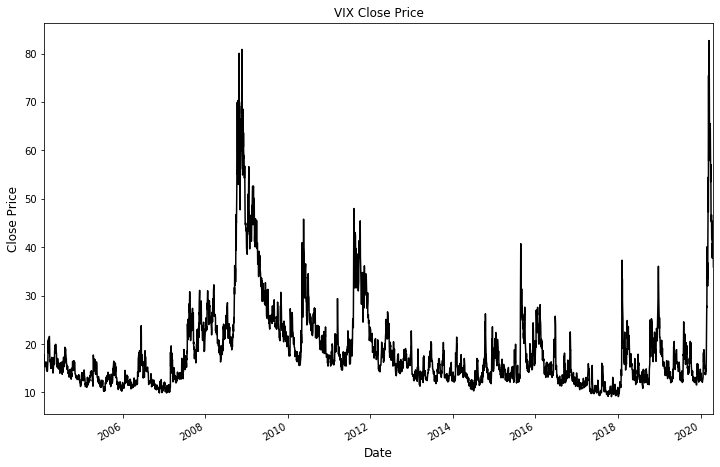

In [4]:
df["VIX Close"][20:].plot(figsize=(12,8),color="Black",title="VIX Close Price",fontsize=10)
plt.ylabel('Close Price', fontsize=12)
plt.xlabel('Date', fontsize=12)
# df["MA 20"][20:].plot(figsize=(10,5),color="Red")
plt.show()

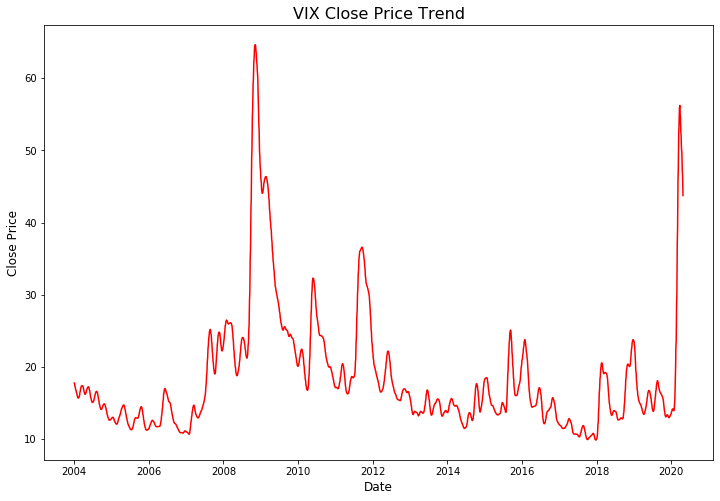

In [5]:
plt.figure(figsize=(12,8))
res = STL(df["VIX Close"],period=30).fit()
plt.plot(res.trend,color='red')
plt.title("VIX Close Price Trend",fontsize=16)
plt.ylabel('Close Price', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.show()

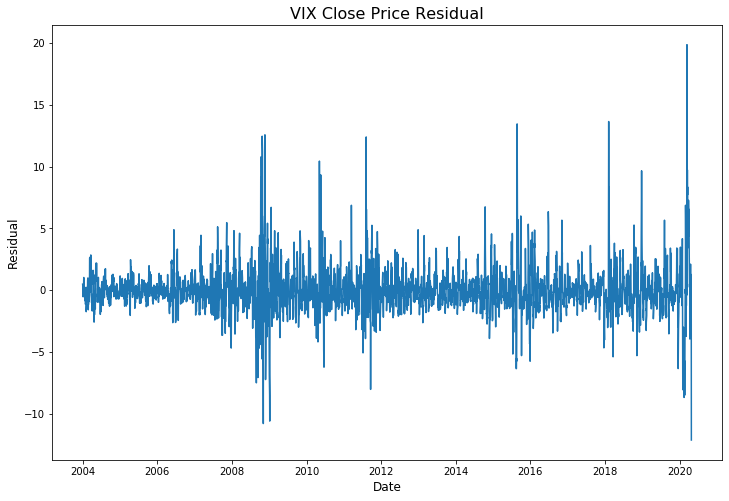

In [6]:
plt.figure(figsize=(12,8))
plt.plot(res.resid)
plt.title("VIX Close Price Residual",fontsize=16)
plt.ylabel('Residual', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.show()

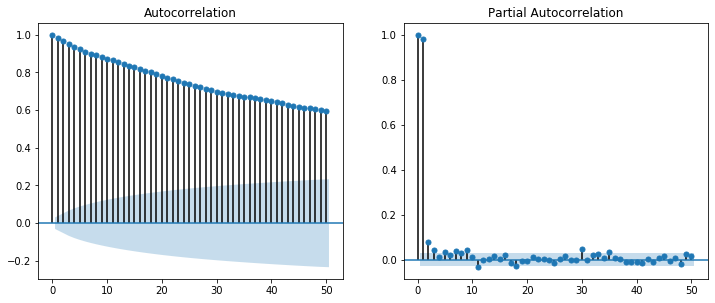

In [7]:
fig = plt.figure(figsize=(12, 16))
ax1 = fig.add_subplot(321)
plot_acf(df["Log.VIX Close"],lags=50,ax=ax1)
ax2 = fig.add_subplot(322)
plot_pacf(df["Log.VIX Close"],lags=50,ax=ax2)
plt.show()

In [8]:
result = adfuller(df["Log.VIX Close"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.278760
p-value: 0.000483
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [9]:
df2=df.copy()
df2["Diff Log"]=df2["Log.VIX Close"].diff()
df2=df2.dropna()
df2.head()

,VIX Close,Log.VIX Close,Diff Log
Date,,,
2004-01-05,17.49,2.861629,-0.040891
2004-01-06,16.73,2.817204,-0.044426
2004-01-07,15.50,2.740840,-0.076363
2004-01-08,15.61,2.747912,0.007072
2004-01-09,16.75,2.818398,0.070487


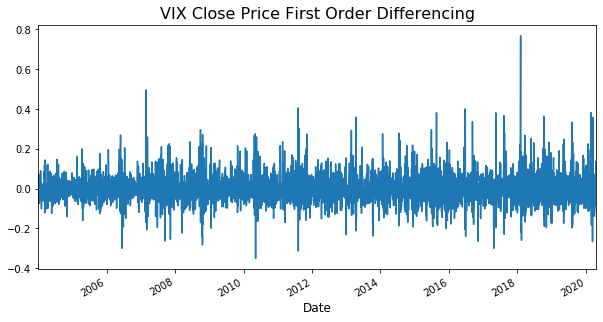

In [10]:
df2["Diff Log"].plot(figsize=(10,5))
plt.title("VIX Close Price First Order Differencing",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.show()

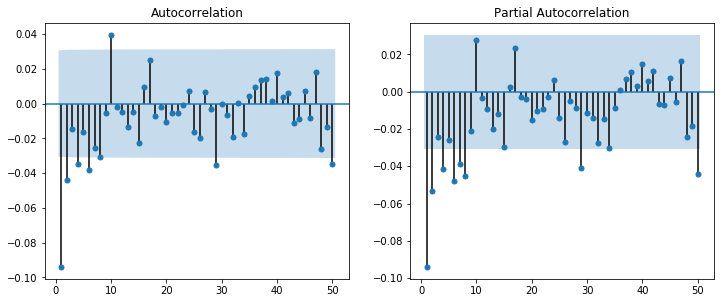

In [11]:
fig = plt.figure(figsize=(12, 16))
ax1 = fig.add_subplot(321)
plot_acf(df2["Diff Log"],lags=50,ax=ax1,zero=False)
ax2 = fig.add_subplot(322)
plot_pacf(df2["Diff Log"],lags=50,ax=ax2,zero=False)
plt.show()

In [12]:
result = adfuller(df2["Diff Log"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -22.951931
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [13]:
split=len(df)-11
df_train=df2[0:split]
df_test=df2[split:]

### Test train split graph

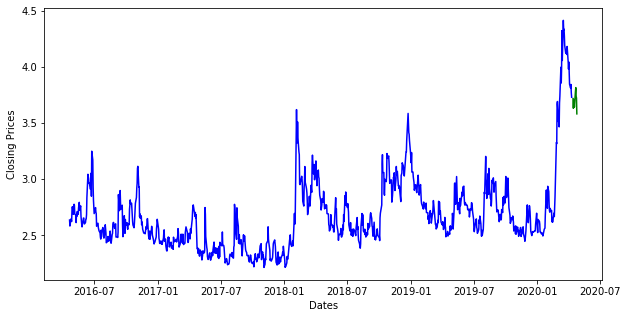

In [14]:
fig = plt.figure(figsize=(10, 5))
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_train["Log.VIX Close"][-1000:], 'blue', label='Train data')
plt.plot(df_test["Log.VIX Close"], 'green', label='Test data')
plt.show()

In [15]:
len(df_test)

10

In [16]:
model_autoARIMA = auto_arima(df_train["Log.VIX Close"], start_p=0, start_q=0,test='adf',max_p=2, max_q=2,m=7,
                             d=1,D=1,seasonal=False,trace=True, ic = "BIC",start_P=1,max_P=2,start_Q=1,max_Q=2,
                             error_action='ignore', suppress_warnings=True,stepwise=False)
print(model_autoARIMA.summary())

Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=-9697.882, BIC=-9685.247, Time=0.299 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=-9736.469, BIC=-9717.517, Time=0.416 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=-9745.289, BIC=-9720.020, Time=0.532 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=-9732.308, BIC=-9713.356, Time=0.167 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=-9769.759, BIC=-9744.490, Time=1.174 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=-9773.828, BIC=-9742.241, Time=2.605 seconds
Fit ARIMA: (2, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=-9742.007, BIC=-9716.738, Time=0.451 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=-9773.314, BIC=-9741.728, Time=2.612 seconds
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=-9765.898, BIC=-9727.994, Time=1.410 seconds
Total fit time: 9.669 seconds
                               SARIMAX Results                        

In [16]:
# model_autoARIMA2 = auto_arima(df_train["Log.VIX Close"], start_p=0, start_q=0,test='adf',max_p=3, max_q=3,m=5,
#                              d=1,D=1,seasonal=True,trace=True, ic = "BIC",start_P=1,max_P=2,start_Q=1,max_Q=2,
#                              error_action='ignore', suppress_warnings=True,stepwise=False)
# print(model_autoARIMA2.summary())

In [17]:
model_autoARIMA.order

(1, 1, 2)

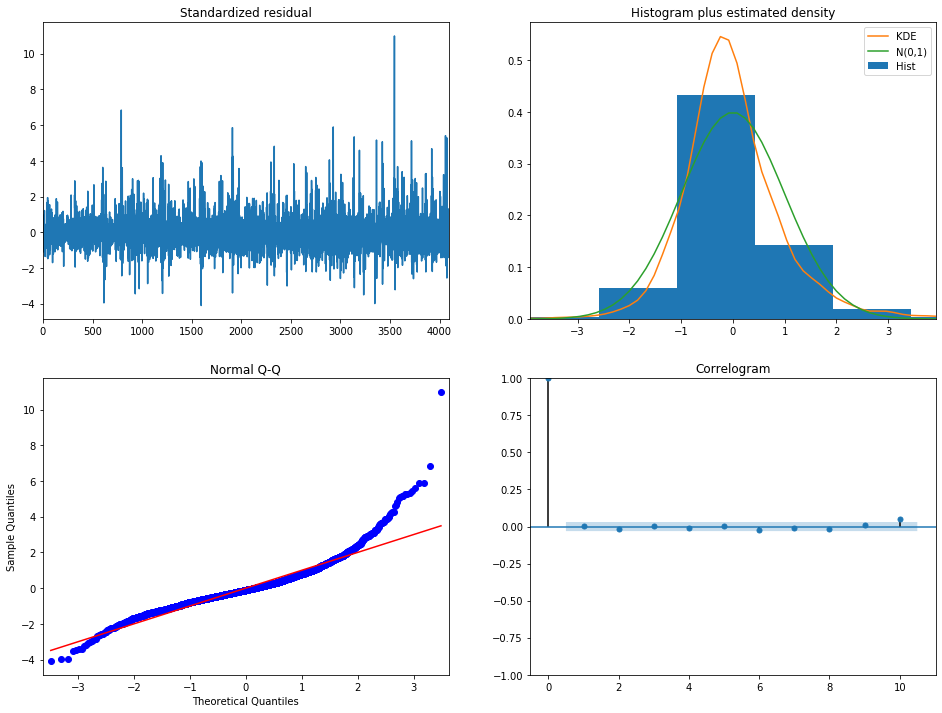

In [18]:
model_autoARIMA.plot_diagnostics(figsize=(16,12))
plt.show()

In [19]:
model = ARIMA(df_train["Log.VIX Close"], order=(1,1,2))   
fitted = model.fit(disp=-1) 
res=fitted.resid
print(fitted.summary())

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:        D.Log.VIX Close   No. Observations:                 4094
Model:                 ARIMA(1, 1, 2)   Log Likelihood                4891.916
Method:                       css-mle   S.D. of innovations              0.073
Date:                Mon, 27 Apr 2020   AIC                          -9773.833
Time:                        17:07:43   BIC                          -9742.246
Sample:                             1   HQIC                         -9762.650
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0002      0.001      0.400      0.689      -0.001       0.001
ar.L1.D.Log.VIX Close     0.9161      0.078     11.810      0.000       0.764       1.068
ma.L1.D.

<Figure size 1500x500 with 0 Axes>

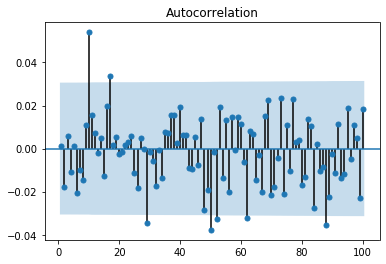

In [20]:
plt.figure(figsize=(15,5), dpi=100)
plot_acf(res,lags=100,zero=False)
plt.show()

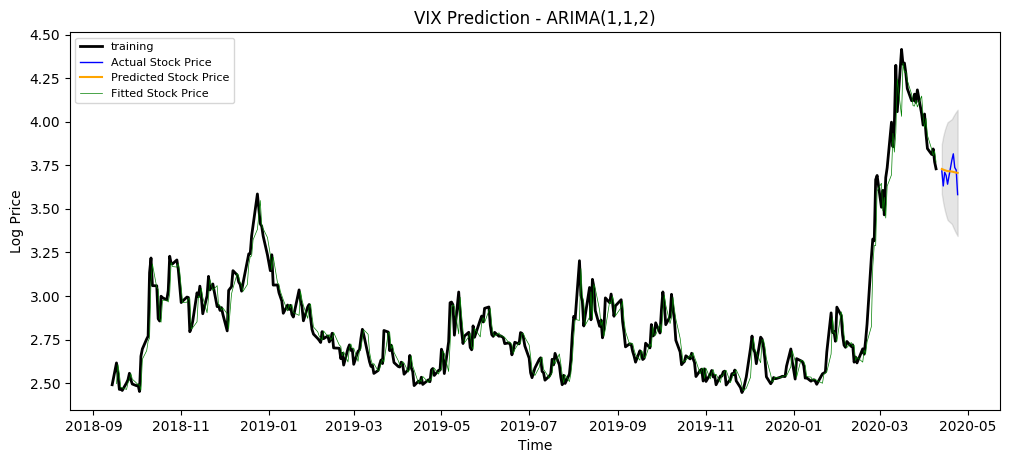

In [21]:
# Forecast
ac=fitted.predict(1,typ='levels')
ac_series=pd.Series(ac, index=df_train.index).dropna()
fc, se, conf = fitted.forecast(len(df_test), alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=df_test.index)
lower_series = pd.Series(conf[:, 0], index=df_test.index)
upper_series = pd.Series(conf[:, 1], index=df_test.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train["Log.VIX Close"][3700:], color="black",label='training',linewidth=2)
plt.plot(df_test["Log.VIX Close"], color = 'blue', label='Actual Stock Price',linewidth=1)
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.plot(ac_series[3700:], color = 'green',label='Fitted Stock Price',linewidth=0.5)
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('VIX Prediction - ARIMA(1,1,2)')
plt.xlabel('Time')
plt.ylabel('Log Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [22]:
# Output from R Forecast on ARIMA(1,1,2)-GARCH

a=[-0.02019326,-0.02019326,-0.01123292,-0.02031822,-0.01506412,-0.01090570,-0.02635679,-0.02386590,
   -0.01400609,-0.01460691]
b=df_train["Log.VIX Close"][-1]
b

3.7297814454343623

In [23]:
# Use the log difference predicted from ARIMA-GARCH to computer predicted price
c=[]
for i in a:
    b+=a
    c.append(b) 

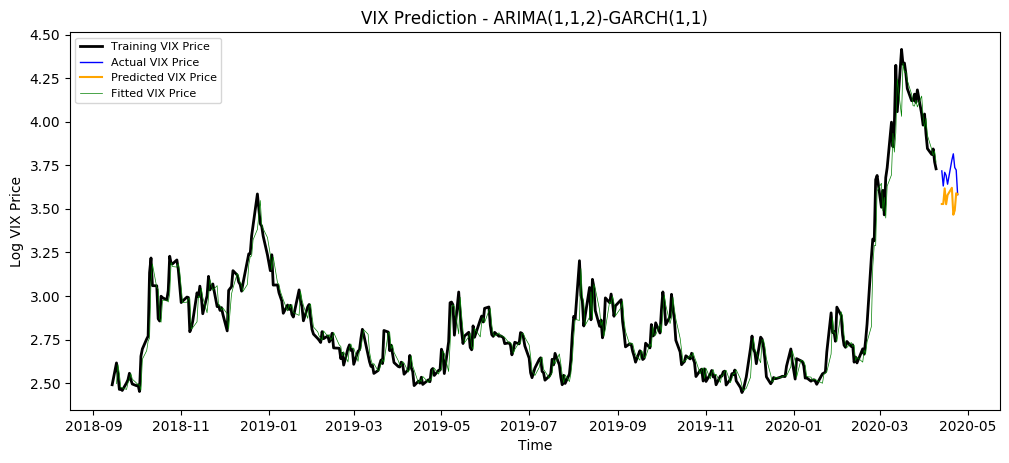

In [24]:
ac_series=pd.Series(ac, index=df_train.index).dropna()
fc_series2 = pd.Series(c[0], index=df_test.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train["Log.VIX Close"][3700:], color="black",label='Training VIX Price',linewidth=2)
plt.plot(df_test["Log.VIX Close"], color = 'blue', label='Actual VIX Price',linewidth=1)
plt.plot(fc_series2, color = 'orange',label='Predicted VIX Price')
plt.plot(ac_series[3700:], color = 'green',label='Fitted VIX Price',linewidth=0.5)
plt.title('VIX Prediction - ARIMA(1,1,2)-GARCH(1,1)')
plt.xlabel('Time')
plt.ylabel('Log VIX Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()